In [44]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from pgmpy.inference import VariableElimination
import warnings
import json
warnings.filterwarnings("ignore")

In [45]:

with open("../../../../data/Weakness.json", 'r+') as weakfile:
    weak = json.load(weakfile)
    weakfile.close()
    
def Generate_Multiplicator(x):
    EnemyType = x["Enemy Type"]
    MoveType = x["Type Move"]
    weakness = 1
    EnemyType = EnemyType.split(",")
    for i in range(len(EnemyType)):
        if i == 0:
            EnemyType[i] = EnemyType[i][2:-1]
        elif i == 1:
            EnemyType[1] = EnemyType[1][2:-2]
    for Type in EnemyType:
        if not Type.isalnum():
            continue
        weakness = weakness * weak[MoveType][Type] 
    return weakness

def percentual_Transform(s):
    
    l = s.split("\/")
    l = list(map(lambda n: int(n),l))
    p = l[0]/l[1] * 100
    
    return p

def check_stab(df):
    new_col = []
    for i in range(len(df)):
        if df['Pokemon Type'][i].split('\'')[1] == df['Type Move'][i] or (len(df['Pokemon Type'][i].split('\'')) > 3 and df['Pokemon Type'][i].split('\'')[3] == df['Type Move'][i]):
            new_col.append(True)
        else:
            new_col.append(False)
    df = df.assign(stab=new_col)
    df = df.drop(['Pokemon Type', 'Type Move'], axis= 1)
    return df

<>:25: SyntaxWarning: invalid escape sequence '\/'
<>:25: SyntaxWarning: invalid escape sequence '\/'
C:\Users\TechRufy\AppData\Local\Temp\ipykernel_9156\4289631374.py:25: SyntaxWarning: invalid escape sequence '\/'
  l = s.split("\/")


In [46]:
df = pd.read_csv("../parsing Dataset/log/Dataset.csv")

df["UserHP"] = df["UserHP"].map(percentual_Transform)
df["SuffererHP"] = df["SuffererHP"].map(percentual_Transform)

df.rename({"UserHP": "Pokemon HP","SuffererHP": "Enemy HP","TypeM": "Type Move",
           "categoryMove": "Category","TypesS" : "Enemy Type","TypesU":"Pokemon Type",
           "power":"Power"}, axis=1, inplace=True)
df["Multiplicator"] = df[["Enemy Type","Type Move"]].apply(Generate_Multiplicator, axis=1)
df = df.drop(["Enemy Type"], axis= 1)
#df["Choose"] = np.ones(len(df)).astype(int)
df = check_stab(df)
df["Weather"] = df["Weather"].str.rstrip().str.lower()
df

,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Choose,Multiplicator,stab
0,Flygon,Aerodactyl\r\n,U-turn,70,100.000000,100.000000,none,physical,1.0,0.50,False
1,Aerodactyl,Bronzong\r\n,Stealth Rock,0,100.000000,100.000000,none,status,1.0,0.50,True
2,Bronzong,Bronzong\r\n,Trick Room,0,100.000000,100.000000,none,status,1.0,0.25,True
3,Bronzong,Forretress\r\n,Earthquake,100,100.000000,100.000000,none,physical,1.0,1.00,False
4,Bronzong,Forretress\r\n,Trick Room,0,100.000000,100.000000,none,status,0.0,0.25,True
...,...,...,...,...,...,...,...,...,...,...,...
1025,Persian,Persian\r\n,Nasty Plot,0,100.000000,100.000000,none,status,1.0,1.00,False
1026,Entei,Persian\r\n,Sacred Fire,100,72.638436,100.000000,none,physical,1.0,1.00,True
1027,Persian,Entei\r\n,Dark Pulse,80,100.000000,72.638436,none,special,1.0,1.00,False
1028,Persian,Entei\r\n,Nasty Plot,0,100.000000,100.000000,none,status,0.0,1.00,False


In [47]:
from sklearn.preprocessing import KBinsDiscretizer

enc = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy='uniform')
enc.fit(df[["Pokemon HP"]])
df["Pokemon HP"] = enc.transform(df[["Pokemon HP"]]).astype(int)
enc.fit(df[["Enemy HP"]])
df["Enemy HP"] = enc.transform(df[["Enemy HP"]]).astype(int)
enc = KBinsDiscretizer(n_bins=10, encode='ordinal',strategy='uniform')
enc.fit(df[["Power"]])
df["Power"] = enc.transform(df[["Power"]]).astype(int)
df

C:\Users\TechRufy\PycharmProjects\showdownBayesian\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\TechRufy\PycharmProjects\showdownBayesian\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
C:\Users\TechRufy\PycharmProjects\showdownBayesian\venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitl

,User,Sufferer,name move,Power,Pokemon HP,Enemy HP,Weather,Category,Choose,Multiplicator,stab
0,Flygon,Aerodactyl\r\n,U-turn,2,9,9,none,physical,1.0,0.50,False
1,Aerodactyl,Bronzong\r\n,Stealth Rock,0,9,9,none,status,1.0,0.50,True
2,Bronzong,Bronzong\r\n,Trick Room,0,9,9,none,status,1.0,0.25,True
3,Bronzong,Forretress\r\n,Earthquake,4,9,9,none,physical,1.0,1.00,False
4,Bronzong,Forretress\r\n,Trick Room,0,9,9,none,status,0.0,0.25,True
...,...,...,...,...,...,...,...,...,...,...,...
1025,Persian,Persian\r\n,Nasty Plot,0,9,9,none,status,1.0,1.00,False
1026,Entei,Persian\r\n,Sacred Fire,4,7,9,none,physical,1.0,1.00,True
1027,Persian,Entei\r\n,Dark Pulse,3,9,7,none,special,1.0,1.00,False
1028,Persian,Entei\r\n,Nasty Plot,0,9,9,none,status,0.0,1.00,False


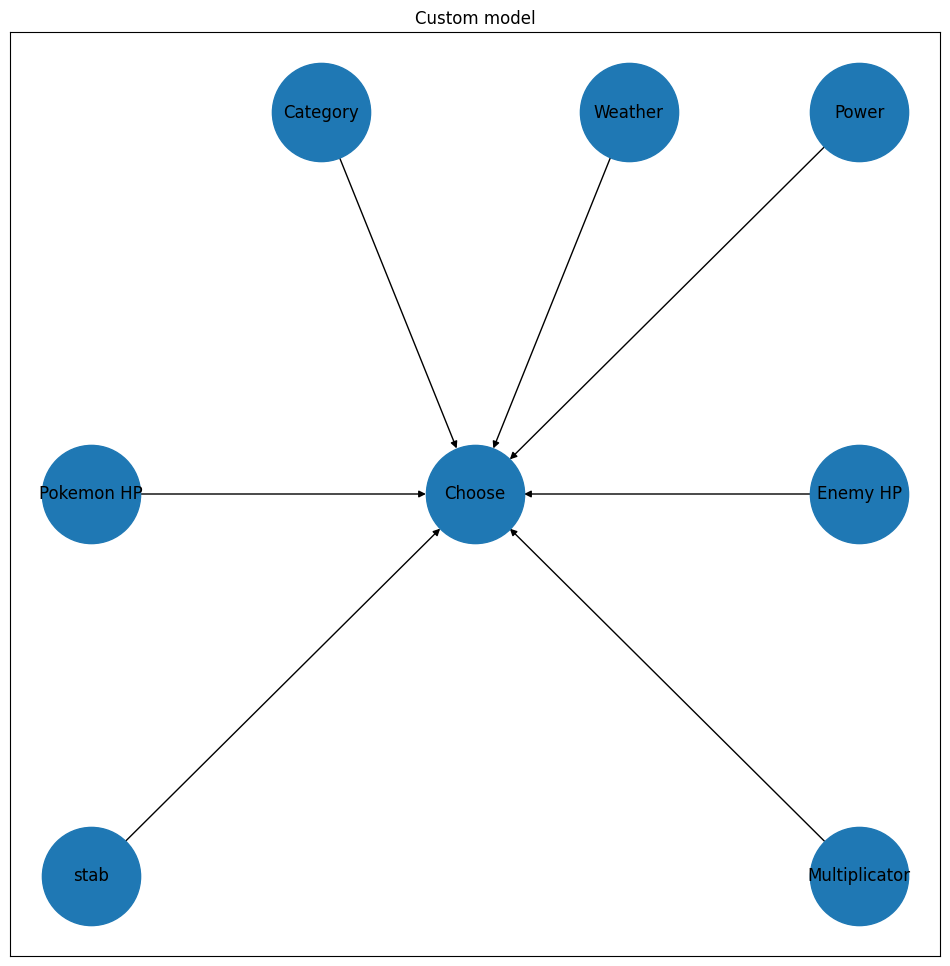

In [48]:
custom_model = BayesianNetwork([('Pokemon HP', 'Choose'), ('Enemy HP', 'Choose'),
                              ('stab', 'Choose'), ('Multiplicator', 'Choose'), ('Power', 'Choose'),
                               ("Weather","Choose"), ("Category","Choose")])
pos = {'Pokemon HP': [0.75, -0.5], 'Enemy HP': [1.25, -0.5],
       "stab": [0.75, -1.], 'Multiplicator': [1.25, -1],
       'Power': [1.25, 0], "Weather" : [1.1, 0],
       'Choose': [1, -0.5],"Category" : [0.9, 0]}
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')

In [49]:

estimator = BayesianEstimator(model=custom_model, data=df)

cpds = []
for node in custom_model.nodes():
    cpds.append(estimator.estimate_cpd(node=node, 
                                       prior_type="BDeu", 
                                       equivalent_sample_size=10))
custom_model.add_cpds(*cpds)

print('Checking the model...')
print(f'The model is {custom_model.check_model()}\n\n')

for cpd in [cpd for cpd in custom_model.get_cpds()]:
    print(f'CPD for {cpd.variable}:')
    print(cpd)
    
choose = custom_model.get_cpds("Choose")
print(choose)

Checking the model...
The model is True


CPD for Pokemon HP:
+---------------+------------+
| Pokemon HP(0) | 0.00769231 |
+---------------+------------+
| Pokemon HP(1) | 0.00673077 |
+---------------+------------+
| Pokemon HP(2) | 0.00865385 |
+---------------+------------+
| Pokemon HP(3) | 0.0942308  |
+---------------+------------+
| Pokemon HP(4) | 0.00576923 |
+---------------+------------+
| Pokemon HP(5) | 0.0144231  |
+---------------+------------+
| Pokemon HP(6) | 0.0336538  |
+---------------+------------+
| Pokemon HP(7) | 0.0278846  |
+---------------+------------+
| Pokemon HP(8) | 0.0798077  |
+---------------+------------+
| Pokemon HP(9) | 0.721154   |
+---------------+------------+
CPD for Choose:
+---------------+-----+--------------------+
| Category      | ... | Category(status)   |
+---------------+-----+--------------------+
| Enemy HP      | ... | Enemy HP(9)        |
+---------------+-----+--------------------+
| Multiplicator | ... | Multiplicator(4.0) |
+

In [50]:
import time

EVIDENCE = {'Power': 0,
            'Multiplicator': 4,
            'stab': True,
            'Enemy HP': 1,
            "Pokemon HP": 9}

ordering_heuristics = ['MinFill', 'MinNeighbors','MinWeight','WeightedMinFill']
inference = VariableElimination(custom_model)

def run_query(target_var, evidence, print_output=True):
    probs = []
    for order in ordering_heuristics:
        if print_output:
            print('Using ' + order)
        start = time.time()
        prob = inference.query([target_var],
                              evidence,
                              elimination_order=order,
                              show_progress=False)
        probs.append(prob.get_value(Choose = 1))
        end = time.time() - start
        if print_output:
            print(prob)
            print('----- Query solved in {:.4f} seconds -----\n\n'.format(end))
    return probs

In [51]:
result = run_query(target_var='Choose', evidence=EVIDENCE)
print(result[0])

Using MinFill
+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.5000 |
+-------------+---------------+
| Choose(1.0) |        0.5000 |
+-------------+---------------+
----- Query solved in 0.0711 seconds -----


Using MinNeighbors
+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.5000 |
+-------------+---------------+
| Choose(1.0) |        0.5000 |
+-------------+---------------+
----- Query solved in 0.0671 seconds -----


Using MinWeight
+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.5000 |
+-------------+---------------+
| Choose(1.0) |        0.5000 |
+-------------+---------------+
----- Query solved in 0.0681 seconds -----


Using WeightedMinFill
+-------------+---------------+
| Choose      |   phi(Choose) |
+=============+===============+
| Choose(0.0) |        0.5

In [51]:
df = pd.read_csv("../parsing Dataset/log/Dataset-Switch.csv")



In [ ]:
custom_model = BayesianNetwork([('Pokemon HP', 'Choose'), ('Enemy HP', 'Choose'),
                              ('stab', 'Choose'), ('Multiplicator', 'Choose'), ('Power', 'Choose'),
                               ("Weather","Choose"), ("Category","Choose")])
pos = {'Pokemon HP': [0.75, -0.5], 'Enemy HP': [1.25, -0.5],
       "stab": [0.75, -1.], 'Multiplicator': [1.25, -1],
       'Power': [1.25, 0], "Weather" : [1.1, 0],
       'Choose': [1, -0.5],"Category" : [0.9, 0]}
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
nx.draw_networkx(custom_model, pos=pos, ax=ax, node_size=5000)
ax.set_title('Custom model')
fig.savefig('custom_bn')